This workflow uses a LSTM architecture to forecast pollution levels in Beijing based on a scrolling window of timeseries weather data such as wind speed, wind direction, temperature, atmosphereic pressure, etc. 

The main elements of the workflow are
I. Raw Data Visualization
II. Feature Engineering
    A. One-hot-encoding wind direction
    B. Scaling the features to be between 0 and 1
    C. PCA was done offline, but determined to not help the forecasting
III. Splitting Dataset
    A. Train (used in model training)
    B. Validate (used to score optimal model)
    C. Test (blind test of results)
IV. Generate Y (pollution level) forecasting values for each time step
V. Create batch sequences for train, validate, test datasets
VI. Build LSTM Model
VII. Train and Visualize Learning
VIII. Extract specific time series from test data batches and forecast
IX. Plot Forecasting Results on Test Dataset

Compatibility Note: This workbook if configured to run on NVIDIA RTX GPU. The environment.yml file is configured with tensorflow-gpu and cudatoolkit. Numpy 1.19.5 is required for the LSTM layers.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#Import Packages

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import numpy as np

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten, Dropout, Activation
from keras.utils.vis_utils import plot_model
from keras.callbacks import *
from keras.backend import clear_session

In [2]:
#Model training is significantly faster with GPU computing allowing more 
#hyper-parameter testing
tf.test.is_built_with_cuda()

True

In [3]:
#Check GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Helper functions are saved in src/data/utils.py

In [4]:
# Import helper functions from utils folder
from src.definitions import ROOT_DIR, title_units, colors_quickviz
#Plotting Helper Functions
from src.data.utils import show_raw_visualization, show_heatmap, visualize_loss, niv_show_plot
# Data Scaling Helper Functions
from src.data.utils import niv_minmax_scaler, niv_minmax_inverse_scaler, niv_y_inverted, niv_x_inverted
# Data Preparation Helper Functions
from src.data.utils import series_to_supervised, niv_dataset_split
# Data Forecasting and Array Value Search Function
from src.data.utils import extract_y_indices, niv_forecast_series

In [5]:
#Import Cluster Labels Derived from Hierarchical clustering workflow
path_dataset = ROOT_DIR/'src/data/pollution_formatted.csv'
assert path_dataset.exists()

In [6]:
#Format Dataframe
dataset = pd.read_csv(path_dataset, header=0, index_col=0)
dummy_wind = pd.get_dummies(dataset['wnd_dir'])
dummy_wind.rename(columns={'NE':'Wind NE','NW':'Wind NW', 'SE':'Wind SE','cv':'Wind SW'}, inplace=True)
dataset.drop(columns = ['wnd_dir'], axis=1, inplace=True)
dataset = pd.merge(left=dataset, right=dummy_wind, left_index=True, right_index=True)
feature_keys = list(dataset.columns)
dataset.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain,Wind NE,Wind NW,Wind SE,Wind SW
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023,0.114064,0.322603,0.349087,0.214247
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247,0.317893,0.467477,0.476687,0.410303
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000,1.000000,1.000000,1.000000,1.000000


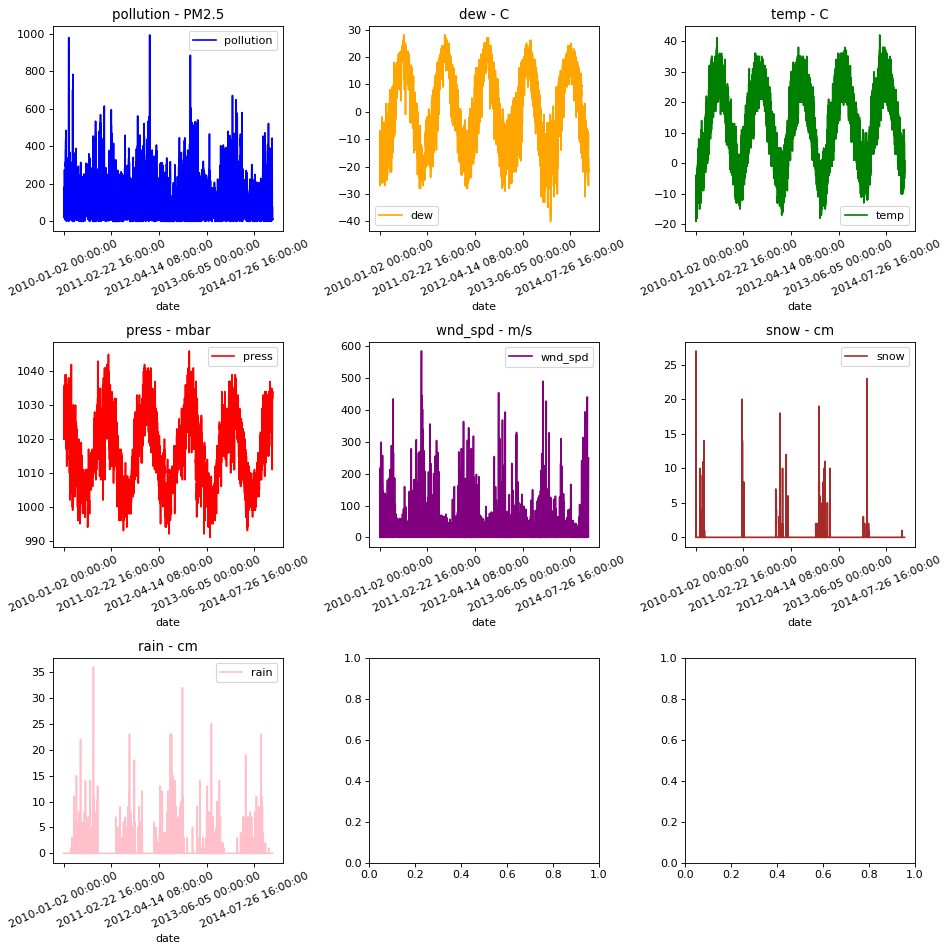

In [7]:
#Visualize Unscaled Data
show_raw_visualization(dataset, feature_keys[0:7], title_units, colors_quickviz)


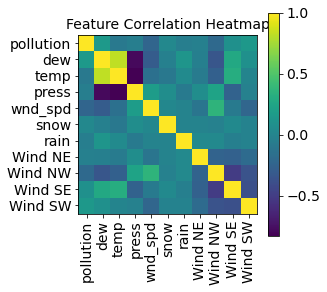

In [8]:
show_heatmap(dataset)

In [9]:
#Scale the data to between 0 and 1, note dataset is hourly
dict_dataset = niv_minmax_scaler(df_in=dataset, feature_range=(0,1))
dataset_scaled = dict_dataset['df_scaled']
dataset_scaled.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,Wind NE,Wind NW,Wind SE,Wind SW
date,,,,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0,0.0,1.0,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0,0.0,1.0,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0,0.0,1.0,0.0


In [10]:
dataset_scaled.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain,Wind NE,Wind NW,Wind SE,Wind SW
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,0.094581,0.615125,0.515722,0.462678,0.040065,0.001954,0.005417,0.114064,0.322603,0.349087,0.214247
std,0.092809,0.212196,0.199892,0.186753,0.085487,0.028170,0.039340,0.317893,0.467477,0.476687,0.410303
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.024145,0.441176,0.344262,0.309091,0.002290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.068410,0.617647,0.540984,0.454545,0.008408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.133048,0.808824,0.688525,0.618182,0.036674,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
#Split dataset into train, validate and test
split_train = 0.70
split_val = 0.20
split_test = 0.10

past = 72 #past data measurements (72 hours)
future = 24 #future forecasting measurements (24 hours)

kwargs = {'data':dataset_scaled,'y_col':0,'split_train':split_train,'split_val':split_val,'split_test':split_test,
          'past':past,'future':future}

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = niv_dataset_split(**kwargs)

In [13]:
X_train.describe()

,dew,temp,press,wnd_spd,snow,rain,Wind NE,Wind NW,Wind SE,Wind SW
count,30659.000000,30659.000000,30659.000000,30659.000000,30659.000000,30659.00000,30659.000000,30659.000000,30659.000000,30659.000000
mean,0.609002,0.503293,0.465129,0.042684,0.002433,0.00586,0.113963,0.330213,0.351871,0.203953
std,0.210928,0.202913,0.188523,0.087053,0.030628,0.04185,0.317772,0.470297,0.477562,0.402941
min,0.161765,0.000000,0.018182,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.426471,0.327869,0.309091,0.002290,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.602941,0.524590,0.454545,0.009929,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.808824,0.688525,0.618182,0.040502,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000
max,1.000000,0.983607,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [14]:
#Time series batches and model training parameters
step = 1 #down sampling, could be used to increment data to decrease model size
sequence_length = int(past / step)

learning_rate = 0.001
batch_size = 32
epochs = 25

In [15]:
#batch the training set data into keras format
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 72, 10)
Target shape: (32, 24)


In [16]:
#batch the validation set data into keras format
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)


Input shape: (32, 72, 10)
Target shape: (32, 24)


In [17]:
#batch the test set data into keras format
dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_test.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 72, 10)
Target shape: (32, 24)


In [18]:
clear_session()
epochs=25

In [19]:
#note numpy 1.19.5 needed to avoid error
input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm1 = keras.layers.LSTM(units=8, return_sequences=True)(input_layer)
lstm1 = keras.layers.Dropout(0.05)(lstm1)
lstm2 = keras.layers.LSTM(units=16, return_sequences=False)(lstm1)
lstm2 = keras.layers.Dropout(.05)(lstm2)
dense1 = keras.layers.Dense(64, activation='relu')(lstm2)
dense2 = keras.layers.Dense(128, activation='relu')(dense1)
output_layer = keras.layers.Dense(future, activation='linear')(dense2)

model_1 = keras.Model(inputs=input_layer, outputs=output_layer)
model_1.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 10)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 72, 8)             608       
_________________________________________________________________
dropout (Dropout)            (None, 72, 8)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320  

In [20]:
run_name = 'Layered_LSTM8_DO20_LSTM16_DO20_D64_D128'
#val_loss
early_stopping = EarlyStopping(monitor='val_loss' ,patience=5, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint("run_{}.h5".format(run_name),monitor='val_loss', save_best_only=True, verbose=1, mode='min')
                                   
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.33, patience=6, min_lr=1e-6, verbose=1, mode='min')


In [21]:
# fit the network
history = model_1.fit(dataset_train, epochs=epochs,
                    validation_data=dataset_val,
                    shuffle=False,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Epoch 1/25
956/956 [==============================] - 16s 14ms/step - loss: 0.0081 - val_loss: 0.0077

Epoch 00001: val_loss improved from inf to 0.00767, saving model to run_Layered_LSTM8_DO20_LSTM16_DO20_D64_D128.h5
Epoch 2/25
956/956 [==============================] - 11s 12ms/step - loss: 0.0077 - val_loss: 0.0077

Epoch 00002: val_loss improved from 0.00767 to 0.00765, saving model to run_Layered_LSTM8_DO20_LSTM16_DO20_D64_D128.h5
Epoch 3/25
956/956 [==============================] - 12s 12ms/step - loss: 0.0077 - val_loss: 0.0075

Epoch 00003: val_loss improved from 0.00765 to 0.00754, saving model to run_Layered_LSTM8_DO20_LSTM16_DO20_D64_D128.h5
Epoch 4/25
956/956 [==============================] - 11s 12ms/step - loss: 0.0076 - val_loss: 0.0074

Epoch 00004: val_loss improved from 0.00754 to 0.00739, saving model to run_Layered_LSTM8_DO20_LSTM16_DO20_D64_D128.h5
Epoch 5/25
956/956 [==============================] - 12s 12ms/step - loss: 0.0076 - val_loss: 0.0071

Epoch 00005: 

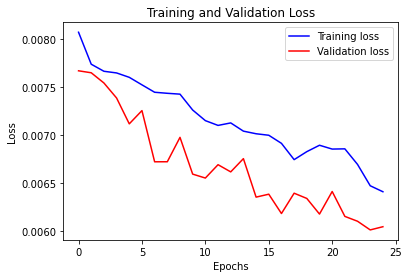

In [22]:
visualize_loss(history, "Training and Validation Loss")

The exponential decay of the loss function is similar to many other neural network training instances in my experience. Having experimented with a number of hyperparameters, the overall loss improves by about 25% at most compared to the initial iteration. It may be that a key driver of observed air pollution may have to do with a factor not measured in the weather dataset. 

In [23]:
#Extract batches from keras Dataset format into lists of numpy arrays
test_batches = list(dataset_test.as_numpy_iterator())

In [24]:
#Querry the test batches for time series of the highest and lowest pollution concentrations
min_series, max_series = extract_y_indices(batches_in=test_batches)

In [25]:
#Forecast a time series based on the lowest observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_1, batches_in=test_batches,
                                             ix_batch=min_series[0], ix_series=min_series[1])

In [26]:
# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

In [27]:
# Visualize the test data and pollution forecast
y_keys = ['dew','temp','wnd_spd','snow','rain']
y_colors = ['tab:blue','tab:orange','tab:green','tab:brown','tab:pink']

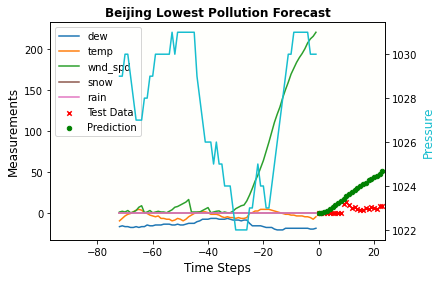

In [28]:
niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title='Beijing Lowest Pollution Forecast')

This time series has the lowest measured pollution values of any -72 hr --> +24 hour series within the test dataset.
Notice the LSTM model captures the increasing pollution trend, but misses the magnitude, particularily after 12 hours.

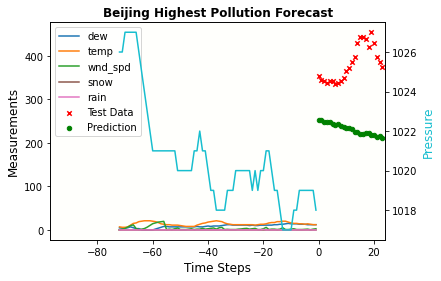

In [29]:
#Forecast a time series based on the highest observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_1, batches_in=test_batches,
                                             ix_batch=max_series[0], ix_series=max_series[1])

# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title='Beijing Highest Pollution Forecast')

This time series has the highest measured pollution values of any -72 hr --> +24 hour series within the test dataset.
Notice the LSTM model captures the decreasing pollution trend in the near-term but misses the magnitude all together. Given the mean pollution value of the dataset is 94, the model hasn't seen enough extreme observations to effectively predict outcomes on the higher end of the distribution.

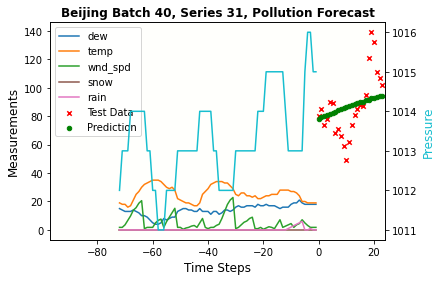

In [30]:
#Arbitrarily select a batch and time series from the batch for prediction
arb_batch=40
arb_series=31
arb_title="Beijing Batch {}, Series {}, Pollution Forecast".format(arb_batch, arb_series)

#Forecast a time series based on a random observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_1, batches_in=test_batches,
                                             ix_batch=arb_batch, ix_series=arb_series)

# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title=arb_title)

This time series is randomly sampled from the test batches.The model correctly predicts the mean of the test values, but misses erratic pollution trends. 


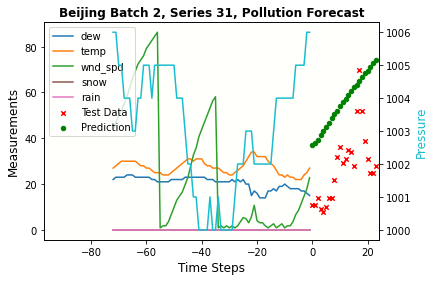

In [31]:
#Arbitrarily select a batch and time series from the batch for prediction
arb_batch=2
arb_series=31
arb_title="Beijing Batch {}, Series {}, Pollution Forecast".format(arb_batch, arb_series)

#Forecast a time series based on a random observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_1, batches_in=test_batches,
                                             ix_batch=arb_batch, ix_series=arb_series)

# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title=arb_title)

In [32]:
#Test simpler model with fewer parameters

In [33]:
clear_session()

In [34]:
#note numpy 1.19.5 needed to avoid error
input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm1 = keras.layers.LSTM(units=8, return_sequences=False)(input_layer)
lstm1 = keras.layers.Dropout(0.2)(lstm1)
dense1 = keras.layers.Dense(4, activation='relu')(lstm1)
output_layer = keras.layers.Dense(future, activation='linear')(dense1)

model_2 = keras.Model(inputs=input_layer, outputs=output_layer)
model_2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 10)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 608       
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                120       
Total params: 764
Trainable params: 764
Non-trainable params: 0
_________________________________________________________________


In [35]:
#This model has fewer parameters than values in the time series of 10 features
run_name = 'Layered_LSTM8_DO20_D4'
#val_loss
early_stopping = EarlyStopping(monitor='val_loss' ,patience=5, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint("run_{}.h5".format(run_name),monitor='val_loss', save_best_only=True, verbose=1, mode='min')
                                   
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.33, patience=6, min_lr=1e-6, verbose=1, mode='min')

# fit the network
history = model_2.fit(dataset_train, epochs=epochs,
                    validation_data=dataset_val,
                    shuffle=False,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Epoch 1/25
956/956 [==============================] - 9s 8ms/step - loss: 0.0092 - val_loss: 0.0080

Epoch 00001: val_loss improved from inf to 0.00798, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 2/25
956/956 [==============================] - 8s 8ms/step - loss: 0.0081 - val_loss: 0.0078

Epoch 00002: val_loss improved from 0.00798 to 0.00782, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 3/25
956/956 [==============================] - 7s 8ms/step - loss: 0.0078 - val_loss: 0.0078

Epoch 00003: val_loss improved from 0.00782 to 0.00778, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 4/25
956/956 [==============================] - 7s 8ms/step - loss: 0.0076 - val_loss: 0.0076

Epoch 00004: val_loss improved from 0.00778 to 0.00762, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 5/25
956/956 [==============================] - 7s 8ms/step - loss: 0.0076 - val_loss: 0.0074

Epoch 00005: val_loss improved from 0.00762 to 0.00743, saving model to run_Layered_LSTM8_DO20_

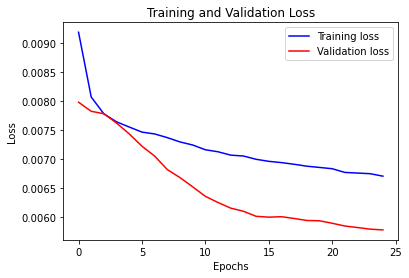

In [36]:
visualize_loss(history, "Training and Validation Loss")

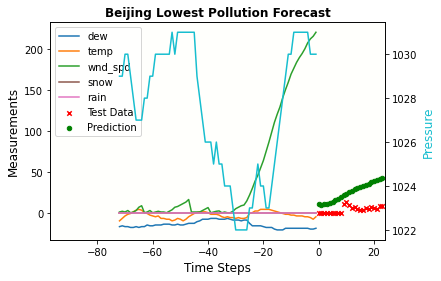

In [37]:
#Extract batches from keras Dataset format into lists of numpy arrays
test_batches = list(dataset_test.as_numpy_iterator())
#Querry the test batches for time series of the highest and lowest pollution concentrations
min_series, max_series = extract_y_indices(batches_in=test_batches)
#Forecast a time series based on the lowest observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_2, batches_in=test_batches,
                                             ix_batch=min_series[0], ix_series=min_series[1])
# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title='Beijing Lowest Pollution Forecast')

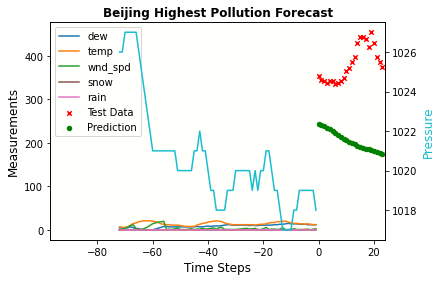

In [38]:
#Extract batches from keras Dataset format into lists of numpy arrays
test_batches = list(dataset_test.as_numpy_iterator())
#Querry the test batches for time series of the highest and lowest pollution concentrations
min_series, max_series = extract_y_indices(batches_in=test_batches)
#Forecast a time series based on the lowest observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_2, batches_in=test_batches,
                                             ix_batch=max_series[0], ix_series=max_series[1])
# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title='Beijing Highest Pollution Forecast')

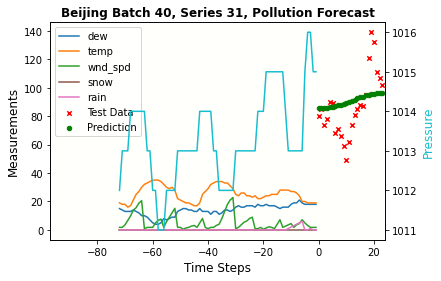

In [39]:
#Arbitrarily select a batch and time series from the batch for prediction
arb_batch=40
arb_series=31
arb_title="Beijing Batch {}, Series {}, Pollution Forecast".format(arb_batch, arb_series)

#Forecast a time series based on a random observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_2, batches_in=test_batches,
                                             ix_batch=arb_batch, ix_series=arb_series)

# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title=arb_title)

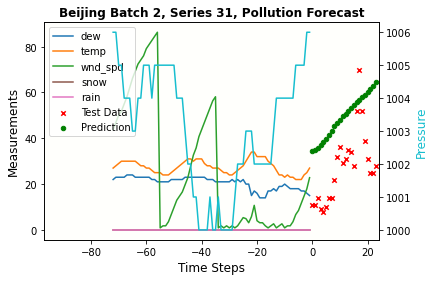

In [40]:
#Arbitrarily select a batch and time series from the batch for prediction
arb_batch=2
arb_series=31
arb_title="Beijing Batch {}, Series {}, Pollution Forecast".format(arb_batch, arb_series)

#Forecast a time series based on a random observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_2, batches_in=test_batches,
                                             ix_batch=arb_batch, ix_series=arb_series)

# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title=arb_title)

In [41]:
clear_session()

In [42]:
#note numpy 1.19.5 needed to avoid error
input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm1 = keras.layers.LSTM(units=1, return_sequences=False)(input_layer)
output_layer = keras.layers.Dense(future, activation='linear')(lstm1)

model_3 = keras.Model(inputs=input_layer, outputs=output_layer)
model_3.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 72, 10)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 48        
_________________________________________________________________
dense (Dense)                (None, 24)                48        
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [43]:
#This model has fewer parameters than values in the time series of 10 features
run_name = 'Layered_LSTM8_DO20_D4'
#val_loss
early_stopping = EarlyStopping(monitor='val_loss' ,patience=5, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint("run_{}.h5".format(run_name),monitor='val_loss', save_best_only=True, verbose=1, mode='min')
                                   
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.33, patience=6, min_lr=1e-6, verbose=1, mode='min')

# fit the network
history = model_3.fit(dataset_train, epochs=epochs,
                    validation_data=dataset_val,
                    shuffle=False,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], 
                    verbose=1)

Epoch 1/25
956/956 [==============================] - 7s 6ms/step - loss: 0.0109 - val_loss: 0.0083

Epoch 00001: val_loss improved from inf to 0.00827, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 2/25
956/956 [==============================] - 6s 6ms/step - loss: 0.0086 - val_loss: 0.0079

Epoch 00002: val_loss improved from 0.00827 to 0.00790, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 3/25
956/956 [==============================] - 6s 6ms/step - loss: 0.0081 - val_loss: 0.0077

Epoch 00003: val_loss improved from 0.00790 to 0.00772, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 4/25
956/956 [==============================] - 6s 6ms/step - loss: 0.0079 - val_loss: 0.0076

Epoch 00004: val_loss improved from 0.00772 to 0.00761, saving model to run_Layered_LSTM8_DO20_D4.h5
Epoch 5/25
956/956 [==============================] - 6s 6ms/step - loss: 0.0078 - val_loss: 0.0075

Epoch 00005: val_loss improved from 0.00761 to 0.00752, saving model to run_Layered_LSTM8_DO20_

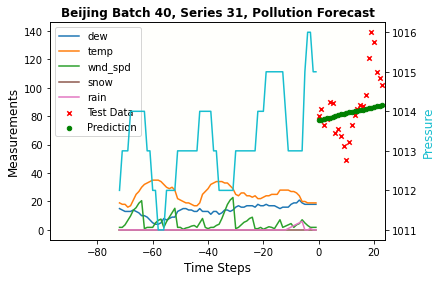

In [44]:
#Arbitrarily select a batch and time series from the batch for prediction
arb_batch=40
arb_series=31
arb_title="Beijing Batch {}, Series {}, Pollution Forecast".format(arb_batch, arb_series)

#Forecast a time series based on a random observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_3, batches_in=test_batches,
                                             ix_batch=arb_batch, ix_series=arb_series)

# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title=arb_title)

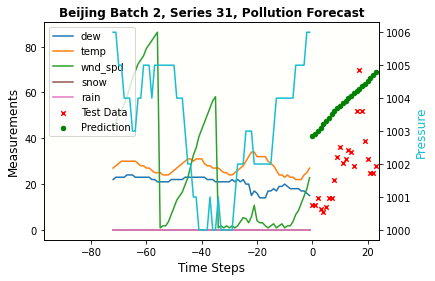

In [45]:
#Arbitrarily select a batch and time series from the batch for prediction
arb_batch=2
arb_series=31
arb_title="Beijing Batch {}, Series {}, Pollution Forecast".format(arb_batch, arb_series)

#Forecast a time series based on a random observed pollution
batch_X, y_data, y_hat = niv_forecast_series(model_in=model_3, batches_in=test_batches,
                                             ix_batch=arb_batch, ix_series=arb_series)

# Rescale the data using the inverse MinMax scaler
y_inverted = niv_y_inverted(y=y_data, dict_in=dict_dataset)
y_hat_inverted = niv_y_inverted(y=y_hat, dict_in=dict_dataset)

X_inverted = niv_x_inverted(X=batch_X, dict_in=dict_dataset)

X_inverted['time_steps'] = list(range(-(X_inverted.shape[0]), 0))
y_hat_inverted['future_steps'] = list(range(y_hat_inverted.shape[0]))
y_inverted['future_steps'] =list(range(y_inverted.shape[0]))

niv_show_plot(df_X=X_inverted, y_data=y_inverted, y_hat=y_hat_inverted,
              y_keys=y_keys, y_colors=y_colors, feature_keys=feature_keys,
              title=arb_title)

Interesting that more sophisticated models with more paremeters converge at about the same level of RMSE validation error. One might conclude that key drivers of the measured pollution values may be missing from the dataset.